<a href="https://colab.research.google.com/github/alessandronicolini/IncrementalLearning/blob/main/mnemonics_runcompleta_exemplarcasuali_noupdatevecchimenmomics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install 'import_ipynb'
!pip3 install 'tqdm'
 
!rm -r IncrementalLearning
# upload work files from your git hub repository
import sys
 
!git clone https://github.com/alessandronicolini/IncrementalLearning.git # clone proj repository
!rm -rf IncrementalLearning/README.md 
!rm -rf IncrementalLearning/baselines.ipynb
 
path = 'IncrementalLearning/'
if path not in sys.path:
    sys.path.append('IncrementalLearning/')
 
!pip3 install import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=74f3559862d7641725d557c986c9b9c9a4ac1c8905d9a2876c08571048f0431a
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb
rm: cannot remove 'IncrementalLearning': No such file or directory
Cloning into 'IncrementalLearning'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 596 (delta 75), reused 0 (delta 0), pack-reused 474
Receiving objects: 100% (596/596), 672.95 KiB | 10.35 MiB/s, done.
Resolving deltas: 100% (350/350), done.


In [2]:
import numpy as np
import torch
from torchvision import transforms
from torchvision.datasets import VisionDataset
from PIL import Image
import random
import torchvision
ROOT = './data'
class ilCIFAR100(VisionDataset):
    """
    Extends CIFAR100 class. Split the dataset into 10 batches, each one containing 10 classes.
    You can retrieve the batches from the attribute "batches", it has different structure according to
    test and train CIFAR100 splits:
        - train -> batches is a dictionary {0:{'train':indexes, 'val':indexes}...} 
        - test -> batches is a dictionary {0:indexes...}
    where the keys are the batch number.

    Args:
        root (string): Root directory of dataset where directory
            `cifar-10-batches-py` exists or will be saved to if download is set to True.
        seed(int): used to ensure reproducibility in shuffling operations.
        val_size(float, optional): between 0 and 1, fraction of data used for validation.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that takes in an PIL image
            and returns a transformed version. E.g, `transforms.RandomCrop`
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
    """
    def __init__(self,classes_per_batch, seed, val_size=0.1, train=True, transform=None, target_transform=False, 
    download=True):
        
        super(ilCIFAR100, self).__init__(root=0)
        self.classes_per_batch=classes_per_batch

        
        self.__rs = seed # set random seed 
        self.train=train
        self.__transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
        ])

        self.__transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
        ])
        # if train:
        #     self.batches = self.__make_train_batches(val_size)
        # else:
        #     self.batches = self.__make_test_batches()
        if self.train == 'train':
          self.dataset = torchvision.datasets.CIFAR100(root=ROOT, train=True,
                                            download=True, transform=self.__transform_train)
        elif self.train == 'exemplars':
          self.dataset = torchvision.datasets.CIFAR100(root=ROOT, train=True,
                                            download=True, transform=self.__transform_test)
        else:
          self.dataset = torchvision.datasets.CIFAR100(root=ROOT, train=False,
                                        download=True, transform=self.__transform_test)
          
        self.targets = np.array(self.dataset.targets) # make targets an array to exploit masking
        random.seed(seed)
        self.classes = random.sample(range(0, 100), 100)
        #self.classes = self.classes.reshape((10, -1)) # each row contains the classes for the corrisponding batch
        #print(self.classes)
        self.__dictionary = {}
        for i, c in enumerate(self.classes):
          self.__dictionary[c] = i


    def get_dict(self):
      return self.__dictionary
    def __getitem__(self, index):
        return index,self.dataset.__getitem__(index)[0],self.dataset.__getitem__(index)[1]
    def __len__(self):
        return self.dataset.__len__()
    def getbatches(self):
      classlist=self.classes
      batches=[]
      for i in range(0,int(100/self.classes_per_batch)):
        #print(i)
        batch=classlist[int(i*self.classes_per_batch):int(i*10+self.classes_per_batch)]
        batches.append(batch)
      return batches
    def get_batch_indexes(self):
      classlist=self.classes
      numclass=self.classes_per_batch
      batch_indexes=[]
      for i in range(0,int(100/self.classes_per_batch)):
        batch=classlist[int(i*numclass):int(i*numclass+numclass)]
        mask=np.isin(self.targets,batch)
        indexes=np.array(np.arange(len(self.dataset.targets)))
        indexes=indexes[mask]
        batch_indexes.append(indexes)
      return batch_indexes
    def get_class_indexes(self,label):
      indexes = np.array(np.arange(len(self.dataset.targets)))
      labels = self.dataset.targets
      mask = np.isin(labels, label)
      indexes = indexes[mask]

      return indexes
    def get_train_val(self,valid):
      batches=self.get_batch_indexes()
      train=[]
      val=[]
      for batch in batches:
        #print(type(batch))
        random.shuffle(batch)
        valbatch=batch[0:int(valid*len(batch))]
        trainbatch=batch[int(valid*len(batch)):]
        train.append(trainbatch)
        val.append(valbatch)
      return train,val
import torch
import torch.optim as optim
import torchvision
import time
import os
import argparse
import numpy as np

def tensor2im(input_image, imtype=np.uint8):
    mean = [0.5071, 0.4867, 0.4408]
    std = [0.2675, 0.2565, 0.2761]
    if not isinstance(input_image, np.ndarray):
        if isinstance(input_image, torch.Tensor):
            image_tensor = input_image.data
        else:
            return input_image
        image_numpy = image_tensor.cpu().detach().float().numpy()
        if image_numpy.shape[0] == 1:
            image_numpy = np.tile(image_numpy, (3, 1, 1))
        for i in range(len(mean)): 
            image_numpy[i] = image_numpy[i] * std[i] + mean[i]
        image_numpy = image_numpy * 255
        image_numpy = np.transpose(image_numpy, (1, 2, 0))
    else:
        image_numpy = input_image
    return image_numpy.astype(imtype)

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import math
from sklearn.preprocessing import normalize
import copy
import torchvision.datasets as dsets
import torchvision.models as models
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torch.utils.data import Subset, DataLoader, Dataset
import random
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd

import import_ipynb
#from IncrementalLearning.cifar100 import ilCIFAR100

from IncrementalLearning.resnet_cifar import resnet32
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

importing Jupyter notebook from /content/IncrementalLearning/resnet_cifar.ipynb


In [6]:
class mnemonics():
  def __init__(self, randomseed):
    self.device = 'cuda'
    self.model = resnet32(num_classes=100).to(self.device)
    self.feature_extractor = self.model.features
    self.temp_model = None
    self.lr = 2
    self.gamma = 0.2
    self.weight_decay = 1e-5 
    self.milestones = [49,63]
    self.batch_size = 128
    self.numepochs = 70
    self.n_classes = 0
    self.n_known = 0
    self.feature_size=64
    self.momentum=0.9
    self.criterion = nn.BCEWithLogitsLoss()

    self.NUM_BATCHES=10
    self.randomseed=randomseed
    self.trainloader=None
    self.testloader=None
    self.CLASSES_PER_BATCH=10

    self.original_training_set = ilCIFAR100(self.CLASSES_PER_BATCH, self.randomseed, train = 'train')
    self.original_exemplar_set = ilCIFAR100(self.CLASSES_PER_BATCH, self.randomseed, train = 'exemplars')
    self.original_test_set = ilCIFAR100(self.CLASSES_PER_BATCH,self.randomseed, train= 'test')

    self.last_test = None
    self.y_pred = []
    self.y_test = []

    self.cumulative_class_mean = []

    self.classes_seen=0
    self.diz = self.original_training_set.get_dict()

    self.exemplar_features_mean = None
    # lista di liste, ogni lista contiene gli exemplars di una classe
    self.exemplar_sets_idxs = [] # mn_exemplat_sets
    # lista unica, tutti gli indici degli exemplar
    self.exemplar_idxs = []


  def update_params(self, 
                    m,
                    finetuning_idxs, 
                    training_idxs, 
                    batch_classes,
                    mnemonics_to_optimize, 
                    batch_size,
                    new=True,
                    lr=0.01, 
                    momentum=0.9, 
                    weight_decay=1e-5, 
                    milestones=[10, 20, 30, 40],
                    gamma=0.5, 
                    tuning_epochs=2,
                    updating_epochs=30):
    
    """
    finetuning_idxs = indexes of current task elements
    mnemonics_idxs = indexes of exemplar elements
    mnemonics_to_optimize = the optimized parameters in the update phase
    """

    # make a copy of the model
    model_copy = copy.deepcopy(self.model)
    model_copy.train()
    model_copy.to(self.device)

    # define the loss
    # criterion = nn.BCEWithLogitsLoss()

    # FINE TUNING FOR 1 EPOCH eq. 8 --------------------------------------------
    
    # define optimizer and scheduler for fine tuning phase
    optimizer = optim.SGD(model_copy.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    
    # create the subset dataset to load the data you want, and the loader
    finetuning_labels = np.array([self.original_training_set.__getitem__(idx)[2] for idx in finetuning_idxs], dtype=int)
    meta_idxs = [i for i in range(len(finetuning_idxs))]
    random.shuffle(meta_idxs)

    # split the meta idxs in batches
    n_batches = int(np.floor(len(finetuning_idxs)/batch_size))
    meta_idxs_batches = []
    for i in range(n_batches):
      meta_idxs_batches.append(np.array(meta_idxs[batch_size*i:batch_size*(i+1)]))
    meta_idxs_batches.append(np.array(meta_idxs[batch_size*n_batches:]))

    # now fine tune the copied model
    for epoch in range(tuning_epochs):
      for meta_idxs_batch in meta_idxs_batches:
        inputs = mnemonics_to_optimize[0][meta_idxs_batch] # are already in cuda
        labels = finetuning_labels[meta_idxs_batch]
        labels = torch.tensor([self.diz[c] for c in labels])
        labels = labels.to(self.device)
        optimizer.zero_grad()
        outputs = model_copy(inputs)
        labels_encoded = F.one_hot(labels,100).float().to(self.device)
        loss = self.criterion(outputs, labels_encoded)
        loss.backward()
        optimizer.step()
    

    # UPDATE THE MNEMONICS eq.9/10 ---------------------------------------------
    
    model_copy.eval()
    
    optimizer = optim.SGD(mnemonics_to_optimize, lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    

    if new:
      exlvl_training = Subset(self.original_training_set, training_idxs)
      exlvl_loader = DataLoader(exlvl_training, batch_size=batch_size, shuffle=True, num_workers=4)

      current_task_labels = set([self.original_training_set.__getitem__(idx)[2] for idx in training_idxs])
      new_dict = {label:i for i,label in enumerate(batch_classes)}
      print('new:',new_dict)
      print('total:', self.diz)
      new_class_mean = {new_dict[key] : value for key, value in self.cumulative_class_mean.items()}
      #print('newdict', new_dict)
      #print('cumulative', self.cumulative_class_mean)
      #print('new class mean', new_class_mean)
      #print('sorted', sorted(new_class_mean.items()))
      means_ready = torch.Tensor(list(new_class_mean.values())).to(self.device)

    
    else:
      exlvl_training = Subset(self.original_exemplar_set, training_idxs)
      exlvl_loader = DataLoader(exlvl_training, batch_size=batch_size, shuffle=True, num_workers=4)


    for epoch in tqdm(range(updating_epochs)):
      for _, inputs, labels in exlvl_loader:

        if new:
          labels = torch.tensor([new_dict[c.item()] for c in labels])
        else:
          labels = torch.tensor([self.diz[c.item()] for c in labels])

        labels = labels.to(self.device)
        #print(labels)
        inputs = inputs.to(self.device)
        #print(inputs)
        out_features = model_copy.features(inputs)
        # compute features mean of mnemonics for each class
        all_class_means = torch.zeros((0, 64))
        all_class_means = all_class_means.to(self.device)
        n_classes = int(len(finetuning_labels)/m)
        if new:
          the_logits = F.linear(F.normalize(out_features, p=2, dim=1), F.normalize(means_ready, p=2, dim=1))
        else:
          for i in range(n_classes): # how many classes
            mnemonics_features = model_copy.features(mnemonics_to_optimize[0][i*m:(i+1)*m])
            #print(mnemonics_features.shape)
            this_class_means = torch.mean(mnemonics_features, dim=0) # size 64
            this_class_means = torch.unsqueeze(this_class_means, dim=0) # add the second dimension
            all_class_means = torch.cat((all_class_means, this_class_means), dim=0)
          the_logits = F.linear(F.normalize(out_features, p=2, dim=1), F.normalize(all_class_means, p=2, dim=1))
        labels_encoded = F.one_hot(labels,100).float().cuda()
        loss = F.cross_entropy(the_logits, labels) # al secondo batch di classi per i new mnemonics le uscite sono sempre 10 ma le label vanno da 10 a 19
        loss.backward()
        optimizer.step()

  def exemplar_level_optimization(self, m, task_num, current_task_indices,batch_classes):  
    
    # UPDATING NEW EXEMPLAR-----------------------------------------------------

    # isola gli indici dei nuovi exemplars
    new_exemplar_idxs = []
    for idxs in self.exemplar_sets_idxs[-10:]:
      new_exemplar_idxs += idxs

    # ora ottieni gli mnemonics che poi sono da ottimizzare
    new_mnemonics_data = torch.zeros((10*m, 3, 32, 32))

    for i, idx in enumerate(new_exemplar_idxs):
      new_mnemonics_data[i, :, :, :] = self.original_training_set.__getitem__(int(idx))[1]

    new_mnemonics = nn.ParameterList()
    new_mnemonics.append(nn.Parameter(new_mnemonics_data))
    new_mnemonics.to(self.device)
    
    #print(new_mnemonics[0][0])

    options_new ={'finetuning_idxs': new_exemplar_idxs, 
                  'training_idxs': current_task_indices, 
                  'batch_classes':batch_classes,
                  'mnemonics_to_optimize':  new_mnemonics,  
                  'batch_size':128,
                  'm':m}

    print('---start mnemonics updating---')

    self.update_params(**options_new)    

    for i, idx in enumerate(new_exemplar_idxs):
      self.original_exemplar_set.dataset.data[idx] = tensor2im(new_mnemonics[0][i])

    
    # UPDATING OLD EXEMPLARS ---------------------------------------------------
    '''
    if task_num:
      # decidi quanti elementi ha ogni exemlar set in a e in b a seconda se m è 
      # pari o dispari
      if m%2:
        l_a = int((m+1)/2)
      else:
        l_a = int(m/2)
      l_b = int(m-l_a)

      # isola gli indici dei vecchi exemplars, dividendoli in due parti
      # ogni classe deve avere circa la metà degli exemplar originali
      old_exemplar_idxs_a = []
      old_exemplar_idxs_b = []
      
      for idxs in self.exemplar_sets_idxs[:-10]:
        old_exemplar_idxs_a += idxs[:l_a]
        old_exemplar_idxs_b += idxs[l_a:]

      old_mnemonics_data_a = torch.zeros((task_num*10*l_a, 3, 32, 32))
      old_mnemonics_data_b = torch.zeros((task_num*10*l_b, 3, 32, 32))

      for i, idx in enumerate(old_exemplar_idxs_a):
        old_mnemonics_data_a[i, :, :, :] = self.original_training_set.__getitem__(int(idx))[1]
      
      for i, idx in enumerate(old_exemplar_idxs_b):
          old_mnemonics_data_b[i, :, :, :] = self.original_training_set.__getitem__(int(idx))[1]
      
      old_mnemonics_a = nn.ParameterList()
      old_mnemonics_a.append(nn.Parameter(old_mnemonics_data_a))
      old_mnemonics_a.to(self.device)
      old_mnemonics_b = nn.ParameterList()
      old_mnemonics_b.append(nn.Parameter(old_mnemonics_data_b))
      old_mnemonics_b.to(self.device)

      options_old_a = {'finetuning_idxs':old_exemplar_idxs_a, 
                       'training_idxs':old_exemplar_idxs_b, 
                       'mnemonics_to_optimize':old_mnemonics_a, 
                       'batch_size':128,
                       'm': l_a,
                       'new':False}

      options_old_b = {'finetuning_idxs':old_exemplar_idxs_b, 
                       'training_idxs':old_exemplar_idxs_a, 
                       'mnemonics_to_optimize':old_mnemonics_b, 
                       'batch_size':128,
                       'm':l_b,
                       'new':False}

      self.update_params(**options_old_a) 
      self.update_params(**options_old_b)

      # CONVERT AND STORE UPDATED EXEMPLAR as numpy array

      for i, idx in enumerate(old_exemplar_idxs_a):
        self.original_training_set.dataset.data[idx] = tensor2im(old_mnemonics_a[0][i])

      for i, idx in enumerate(old_exemplar_idxs_b):
        self.original_training_set.dataset.data[idx] = tensor2im(old_mnemonics_b[0][i])
    
    '''

    # FINE TUNE THE CURRENT NET ON ALL THE EXEMPLARS COLLECTED 'TILL NOW
    

  def model_level_optimization(self):
    
    old_model = copy.deepcopy(self.model)
    old_model.eval()
    old_model.to(self.device)
    n_classes = self.classes_seen+self.CLASSES_PER_BATCH
    print(n_classes)
    optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.milestones, gamma=self.gamma)
    for epoch in tqdm(range(self.numepochs)):
        
      for _, inputs, labels in self.trainloader:
        inputs = inputs.float().to(self.device)
        labels = torch.tensor([self.diz[c.item()] for c in labels])

        labels=labels.to(self.device)
        optimizer.zero_grad()
        outputs=self.model(inputs)

        labels_encoded = F.one_hot(labels,100).float().to(self.device) #CAMBIARE ONE_HOT
        
        if self.classes_seen:
          old_target = old_model(inputs).to(self.device)
          old_target = torch.sigmoid(old_target).to(self.device)
          
          target = torch.cat((old_target[:,:self.classes_seen], labels_encoded[:, self.classes_seen:]), dim=1)
          loss = self.criterion(outputs, target)
        else:
          loss = self.criterion(outputs, labels_encoded) 

        loss.backward()
        optimizer.step()
      
      scheduler.step()


  def classify_nme(self, input_batch):
    min_distances = float('inf')*torch.ones(len(input_batch)).to(self.device) # shape: batch_size --> 128
    y_pred = torch.zeros(len(input_batch), dtype=torch.int8).to(self.device) # shape: batch_size --> 128
    input_features = self.model.features(input_batch) # shape: (batch_size, feature_size) --> (128, 64)

    for i in range(len(self.exemplar_sets_idxs)):
      ex_mean = self.exemplar_means[i,:]

      # compute distances between inputs features and exemplar set means
      pdist = nn.PairwiseDistance(p=2)
      distances = pdist(input_features, ex_mean) # shape: batch_size --> 128

      # update min distancies and predicted labels
      mask = distances < min_distances
      min_distances[mask] = distances[mask]
      y_pred[mask] = self.exemplar_labels[i]

    return y_pred
    

  def get_new_exemplars(self, batch_indexes, m):
    self.exemplar_sets_idxs.append(random.sample(list(batch_indexes), m))


  def reduce_old_exemplars(self, m):
    for i, set_i in enumerate(self.exemplar_sets_idxs):
      self.exemplar_sets_idxs[i] = random.sample(set_i, m)

  def __accuracy_fc(self, dl, mapper):
    total = 0.0
    correct = 0.0
    for  _, images, labels in dl:
      labels = torch.tensor([torch.tensor(mapper[c.item()]) for c in labels])
      labels = labels.to(self.device)
      images = images.to(self.device)
      outputs = self.model(images)
      _, preds = torch.max(outputs, dim=1)
      total += len(labels)
      correct += torch.sum(preds == labels).item()

    acc = correct / total
    return acc


  def __accuracy_nme(self, dl):
    
    total = 0.0
    correct = 0.0
    
    for  _, images, labels in dl:
      labels = labels.to(self.device)
      images = images.to(self.device)
      preds = self.classify_nme(images)
      total += len(labels)
      correct += torch.sum(preds == labels).item()

      if self.last_test:
        self.y_pred += preds.tolist()
        self.y_test += labels.tolist()

    acc = correct / total
    return acc


  def plot_confusion_matrix(self):
 
    cm = confusion_matrix(self.y_test, self.y_pred)
    cm = np.log(cm+1)
    fig, ax = plt.subplots(figsize=(7,7))
    sns.heatmap(cm, square=True, cbar=False, ax=ax, cmap=plt.get_cmap('seismic'))
    ax.set_xticks(np.linspace(19,99,5))
    ax.set_yticks(np.linspace(19,99,5))
    ax.set_xticklabels([20,40,60,80,100], rotation=0)
    ax.set_yticklabels([20,40,60,80,100], rotation=0)
    ax.set_title("iCaRL")
    ax.set_xlabel("Predicted class")
    ax.set_ylabel("True class")
    plt.savefig("iCaRL_"+str(self.randomseed)+"_cm.png")
    plt.show()
    return cm

  def plot_data(self, dl):

    from sklearn.manifold import TSNE

    labels_array = torch.zeros(0).to('cuda')
    dataset_to_reduce = torch.zeros((0, 64)).to('cuda')

    for  _, images, labels in dl:
      labels = labels.to(self.device)
      images = images.to(self.device)
      dataset_to_reduce = torch.cat((dataset_to_reduce, self.feature_extractor(images)))
      labels_array = torch.cat((labels_array, labels))


    print('example:', dataset_to_reduce[0])
    print('len of dataset to reduce:', dataset_to_reduce[0].shape)
    print('example:', dataset_to_reduce[0][0])
    X_transformed = TSNE(n_components=2).fit_transform(dataset_to_reduce.cpu())
    
    print('shape of transofmed', X_transormed.shape)
    
    fig, ax = plt.subplots(figsize=(15,15))
    ax.scatter(X_transformed[:,0], X_transormed[:,1], c = labels_array)
    plt.show()

   # for idx in data_idxs:
    #  dataset_to_reduce.append([dataset.__getitem__(idx)[1], dataset.__getitem__(idx)[2]])
    
  def trainer(self):
    
    train_indices = self.original_training_set.get_batch_indexes()
    test_indices = self.original_test_set.get_batch_indexes()
    batches=self.original_training_set.getbatches()
    current_test_indexes=[]
    test_acc = []
    self.last_test = False

    for i in range(self.NUM_BATCHES):

      if i == self.NUM_BATCHES-1:
        self.last_test = True

      current_exemplar_indices = np.array([], dtype=int)

      for exemplar_set in self.exemplar_sets_idxs:
        current_exemplar_indices = np.concatenate([current_exemplar_indices, np.array(exemplar_set)])

      exemplar_dataset = Subset(self.original_exemplar_set, current_exemplar_indices)

      train_dataset = Subset(self.original_training_set, train_indices[i])
      current_test_indexes += test_indices[i].tolist()
      test_dataset = Subset(self.original_test_set,current_test_indexes)
      self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4, drop_last=True)
      self.testloader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4, drop_last=True)        
      

      if i == 0:
        self.trainloader = self.train_loader
      else:
        self.trainloader = DataLoader(torch.utils.data.ConcatDataset([train_dataset, exemplar_dataset]), batch_size=self.batch_size, shuffle=True,
          num_workers=4, pin_memory=True)
        
        print('lunghezza train loader:', len(self.trainloader))
        
      self.model.train()
      self.model_level_optimization()    
      self.classes_seen += 10
      self.model.eval() # Set Network to evaluation mode

      #self.plot_data(self.trainloader)

      # update exemplars number
      m=int(2000/(int(i*10+10)))

      # reduce the number of each exemplars set
      self.reduce_old_exemplars(m) 
      
      self.cumulative_class_mean = {}

      for classlabel in batches[i]:
        indexes_class = self.original_training_set.get_class_indexes(classlabel)
        #current_class = Subset(self.original_training_set, indexes_class)
        self.get_new_exemplars(indexes_class, m)
        indexes_class = self.original_training_set.get_class_indexes(classlabel)
        current_class = Subset(self.original_training_set, indexes_class)

        loader = torch.utils.data.DataLoader(current_class, batch_size=self.batch_size,shuffle=False, num_workers=4)
        features = np.zeros((0, 64))
        with torch.no_grad():
          for indexes, images, labels in loader:
            images = images.cuda()
            feature = self.feature_extractor(images).data.cpu().numpy()
            feature = normalize(feature, axis=1, norm='l2')
            features = np.concatenate((features,feature), axis=0)

        class_mean = np.mean(features, axis=0)
        class_mean = class_mean / np.linalg.norm(class_mean)  # Normalize
        #print(class_mean)
        self.cumulative_class_mean[classlabel] = class_mean
        
      print(self.cumulative_class_mean)
      
      if i != 9:
        self.exemplar_level_optimization(m, i, self.original_training_set.get_batch_indexes()[i],batches[i])

      # compute means of exemplar set
      # cycle for each exemplar set
      self.exemplar_means = torch.zeros((0, self.feature_size), dtype=torch.float).to(self.device)
      self.exemplar_labels = []
      for i in range(len(self.exemplar_sets_idxs)):
        exemplars_dataset = Subset(self.original_training_set, self.exemplar_sets_idxs[i])
        exemplars_loader = torch.utils.data.DataLoader(exemplars_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4)
        ex_features = torch.zeros((0, self.feature_size), dtype=torch.float).to(self.device) # alla fine shape: (len(exemplar_set), feature_size) --> (m, 64)
      
        with torch.no_grad():
          _, _, exemplar_label = self.original_training_set.__getitem__(self.exemplar_sets_idxs[i][0]) 
          self.exemplar_labels.append(exemplar_label)
          # cycle for each batch in the current exemplar set
          for _,  exemplars, _ in exemplars_loader:
          
            # get exemplars features
            exemplars = exemplars.to(self.device)
            features = self.model.features(exemplars) # shape: (len(exemplars), feature_size)
          
            # normalize 
            feature_norms = torch.norm(features, p=2, dim=1) # shape: len(exemplars)
            feature_norms.unsqueeze_(1) # shape: (len(exemplars), 1)
            features = features/feature_norms
          
            # concatenate over columns
            ex_features = torch.cat((ex_features, features), dim=0)
          
        # compute current exemplar set mean and normalize it
        ex_mean = torch.mean(ex_features, dim=0) # shape: feature_size --> 64
        ex_mean = ex_mean/torch.norm(ex_mean)
        ex_mean.unsqueeze_(0) # shape: (1, feature_size) --> (1, 64)
        self.exemplar_means = torch.cat((self.exemplar_means, ex_mean), dim=0) # shape: (n_examplar sets, feature size)
      

      print('accuracy on training set:', 100*self.__accuracy_fc(self.trainloader,self.diz))
      # print('accuracy on test set:', self.__accuracy_on(self.testloader,self,self.diz))
      current_test_acc = self.__accuracy_nme(self.testloader)
      print('accuracy on test set:', 100*current_test_acc)
      print('-' * 80)
      test_acc.append(current_test_acc)

    # compute comfusion matrix and save results
    cm = self.plot_confusion_matrix()
    with open('iCaRL_'+str(self.randomseed)+"_cm", 'wb') as file:
      pickle.dump(cm, file, protocol=pickle.HIGHEST_PROTOCOL)
    with open('iCaRL_'+str(self.randomseed)+"_testacc", 'wb') as file:
      pickle.dump(test_acc, file, protocol=pickle.HIGHEST_PROTOCOL)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
10



{11: array([0.01638459, 0.03579479, 0.08042912, 0.11262429, 0.05712083,
       0.18031093, 0.14962201, 0.07170856, 0.01989196, 0.03947628,
       0.02039247, 0.0923399 , 0.21325298, 0.13600775, 0.05605067,
       0.01374655, 0.11305486, 0.18636907, 0.04116505, 0.02857405,
       0.18180612, 0.1559339 , 0.05189704, 0.02305978, 0.06742631,
       0.20251798, 0.17016755, 0.15322366, 0.02810384, 0.03464521,
       0.10619368, 0.37265814, 0.20733943, 0.02611809, 0.20981701,
       0.09992458, 0.15072733, 0.01862122, 0.14640431, 0.06265826,
       0.16837315, 0.01195844, 0.23444214, 0.05918456, 0.04750334,
       0.00762643, 0.01419944, 0.01235574, 0.13365689, 0.1223807 ,
       0.04985727, 0.11435387, 0.31909501, 0.08791462, 0.22407905,
       0.06781972, 0.11262423, 0.01525664, 0.07391638, 0.02236762,
       0.05551444, 0.05720257, 0.05303527, 0.02213326]), 5: array([0.02807082, 0.01691268, 0.23916427, 0.06205777, 0.28642802,
       0.02168154, 0.03357184, 0.20801763, 0.30686065, 0.019676

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


---start mnemonics updating---
new: {11: 0, 5: 1, 62: 2, 76: 3, 27: 4, 3: 5, 96: 6, 33: 7, 78: 8, 30: 9}
total: {11: 0, 5: 1, 62: 2, 76: 3, 27: 4, 3: 5, 96: 6, 33: 7, 78: 8, 30: 9, 2: 10, 31: 11, 44: 12, 82: 13, 12: 14, 16: 15, 15: 16, 13: 17, 71: 18, 87: 19, 73: 20, 92: 21, 75: 22, 48: 23, 56: 24, 25: 25, 63: 26, 86: 27, 38: 28, 9: 29, 58: 30, 69: 31, 91: 32, 22: 33, 83: 34, 89: 35, 93: 36, 51: 37, 81: 38, 8: 39, 90: 40, 32: 41, 55: 42, 23: 43, 4: 44, 40: 45, 54: 46, 59: 47, 18: 48, 43: 49, 95: 50, 21: 51, 53: 52, 20: 53, 94: 54, 14: 55, 99: 56, 64: 57, 47: 58, 60: 59, 98: 60, 39: 61, 57: 62, 74: 63, 72: 64, 84: 65, 34: 66, 97: 67, 88: 68, 24: 69, 77: 70, 67: 71, 42: 72, 1: 73, 61: 74, 35: 75, 46: 76, 66: 77, 29: 78, 26: 79, 65: 80, 28: 81, 79: 82, 10: 83, 37: 84, 80: 85, 36: 86, 52: 87, 50: 88, 0: 89, 45: 90, 68: 91, 6: 92, 85: 93, 70: 94, 49: 95, 17: 96, 7: 97, 19: 98, 41: 99}



accuracy on training set: 98.87820512820514
accuracy on test set: 83.81696428571429
--------------------------------------------------------------------------------
lunghezza train loader: 55
20



{2: array([0.06959425, 0.02522933, 0.01961959, 0.07022347, 0.05682912,
       0.10150653, 0.08641761, 0.05449159, 0.02174295, 0.04927427,
       0.03563304, 0.06160145, 0.17399107, 0.08526898, 0.02596266,
       0.09986169, 0.06520542, 0.07741102, 0.05078646, 0.12700157,
       0.11073426, 0.10030786, 0.16238624, 0.03230802, 0.05482612,
       0.09634779, 0.15463191, 0.12127053, 0.05620127, 0.03167331,
       0.05746619, 0.23946682, 0.25459692, 0.03981862, 0.02716913,
       0.14682799, 0.31948051, 0.06832943, 0.19882139, 0.0800142 ,
       0.37655206, 0.06080044, 0.13709728, 0.17715303, 0.05152835,
       0.03828814, 0.02169456, 0.03714835, 0.11429177, 0.05614566,
       0.07476237, 0.17018463, 0.20174607, 0.25375662, 0.21024072,
       0.10350598, 0.09045282, 0.01896732, 0.18358774, 0.05344204,
       0.04660302, 0.06349276, 0.09316218, 0.03006652]), 31: array([0.03339457, 0.16257702, 0.01759694, 0.10864103, 0.06139089,
       0.16681471, 0.03362898, 0.20356537, 0.06783404, 0.082717

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


---start mnemonics updating---
new: {2: 0, 31: 1, 44: 2, 82: 3, 12: 4, 16: 5, 15: 6, 13: 7, 71: 8, 87: 9}
total: {11: 0, 5: 1, 62: 2, 76: 3, 27: 4, 3: 5, 96: 6, 33: 7, 78: 8, 30: 9, 2: 10, 31: 11, 44: 12, 82: 13, 12: 14, 16: 15, 15: 16, 13: 17, 71: 18, 87: 19, 73: 20, 92: 21, 75: 22, 48: 23, 56: 24, 25: 25, 63: 26, 86: 27, 38: 28, 9: 29, 58: 30, 69: 31, 91: 32, 22: 33, 83: 34, 89: 35, 93: 36, 51: 37, 81: 38, 8: 39, 90: 40, 32: 41, 55: 42, 23: 43, 4: 44, 40: 45, 54: 46, 59: 47, 18: 48, 43: 49, 95: 50, 21: 51, 53: 52, 20: 53, 94: 54, 14: 55, 99: 56, 64: 57, 47: 58, 60: 59, 98: 60, 39: 61, 57: 62, 74: 63, 72: 64, 84: 65, 34: 66, 97: 67, 88: 68, 24: 69, 77: 70, 67: 71, 42: 72, 1: 73, 61: 74, 35: 75, 46: 76, 66: 77, 29: 78, 26: 79, 65: 80, 28: 81, 79: 82, 10: 83, 37: 84, 80: 85, 36: 86, 52: 87, 50: 88, 0: 89, 45: 90, 68: 91, 6: 92, 85: 93, 70: 94, 49: 95, 17: 96, 7: 97, 19: 98, 41: 99}



accuracy on training set: 94.37142857142857
accuracy on test set: 73.07291666666667
--------------------------------------------------------------------------------
lunghezza train loader: 55
30



{73: array([0.13336063, 0.15667129, 0.1799954 , 0.09420728, 0.0734926 ,
       0.04068916, 0.11801647, 0.12634255, 0.08459725, 0.18196894,
       0.10664837, 0.03712092, 0.28113132, 0.05073645, 0.05508265,
       0.12916628, 0.03302513, 0.03933149, 0.13332277, 0.0830567 ,
       0.33955493, 0.05872281, 0.13128035, 0.13723582, 0.10724439,
       0.08197074, 0.07833116, 0.05646513, 0.27148923, 0.0609654 ,
       0.15374627, 0.04915406, 0.0326777 , 0.05503955, 0.03729358,
       0.02977367, 0.17305995, 0.19323094, 0.16855081, 0.12166345,
       0.05403758, 0.05493545, 0.02894974, 0.07967809, 0.04655042,
       0.09069627, 0.28199641, 0.0777573 , 0.03817705, 0.04020627,
       0.14533705, 0.04603479, 0.03593094, 0.13325227, 0.15679047,
       0.0667411 , 0.05409809, 0.06817001, 0.06594505, 0.02965803,
       0.06508799, 0.22638269, 0.02455726, 0.20664545]), 92: array([0.08549578, 0.12207726, 0.07723856, 0.09548286, 0.05458881,
       0.09901558, 0.08270025, 0.18928938, 0.02412889, 0.15399

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


---start mnemonics updating---
new: {73: 0, 92: 1, 75: 2, 48: 3, 56: 4, 25: 5, 63: 6, 86: 7, 38: 8, 9: 9}
total: {11: 0, 5: 1, 62: 2, 76: 3, 27: 4, 3: 5, 96: 6, 33: 7, 78: 8, 30: 9, 2: 10, 31: 11, 44: 12, 82: 13, 12: 14, 16: 15, 15: 16, 13: 17, 71: 18, 87: 19, 73: 20, 92: 21, 75: 22, 48: 23, 56: 24, 25: 25, 63: 26, 86: 27, 38: 28, 9: 29, 58: 30, 69: 31, 91: 32, 22: 33, 83: 34, 89: 35, 93: 36, 51: 37, 81: 38, 8: 39, 90: 40, 32: 41, 55: 42, 23: 43, 4: 44, 40: 45, 54: 46, 59: 47, 18: 48, 43: 49, 95: 50, 21: 51, 53: 52, 20: 53, 94: 54, 14: 55, 99: 56, 64: 57, 47: 58, 60: 59, 98: 60, 39: 61, 57: 62, 74: 63, 72: 64, 84: 65, 34: 66, 97: 67, 88: 68, 24: 69, 77: 70, 67: 71, 42: 72, 1: 73, 61: 74, 35: 75, 46: 76, 66: 77, 29: 78, 26: 79, 65: 80, 28: 81, 79: 82, 10: 83, 37: 84, 80: 85, 36: 86, 52: 87, 50: 88, 0: 89, 45: 90, 68: 91, 6: 92, 85: 93, 70: 94, 49: 95, 17: 96, 7: 97, 19: 98, 41: 99}



accuracy on training set: 93.89999999999999
accuracy on test set: 67.32336956521739
--------------------------------------------------------------------------------
lunghezza train loader: 55
40



{58: array([0.06771369, 0.04292997, 0.24256447, 0.08415863, 0.27714686,
       0.07048743, 0.07759733, 0.13281129, 0.13468991, 0.04582425,
       0.13753417, 0.07058023, 0.1515742 , 0.259871  , 0.09065629,
       0.1123287 , 0.29545549, 0.07349945, 0.11499895, 0.19066011,
       0.08281797, 0.08285165, 0.06876481, 0.08287011, 0.07895195,
       0.03916821, 0.10307642, 0.10887544, 0.05523669, 0.05291118,
       0.2725746 , 0.10453935, 0.05622176, 0.04584349, 0.06328074,
       0.08445295, 0.16214237, 0.12235751, 0.11145023, 0.06854371,
       0.07915327, 0.06828888, 0.0947227 , 0.06559692, 0.35370032,
       0.04044093, 0.07366892, 0.07196395, 0.0587546 , 0.05178796,
       0.18585847, 0.08801495, 0.11220598, 0.06523512, 0.05320952,
       0.04441467, 0.05243726, 0.09329622, 0.14310425, 0.0698317 ,
       0.1338357 , 0.08110923, 0.07296605, 0.06920562]), 69: array([0.07989787, 0.12860532, 0.04929893, 0.09544198, 0.07342284,
       0.05739284, 0.18468666, 0.15029907, 0.06484326, 0.04791

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


---start mnemonics updating---
new: {58: 0, 69: 1, 91: 2, 22: 3, 83: 4, 89: 5, 93: 6, 51: 7, 81: 8, 8: 9}
total: {11: 0, 5: 1, 62: 2, 76: 3, 27: 4, 3: 5, 96: 6, 33: 7, 78: 8, 30: 9, 2: 10, 31: 11, 44: 12, 82: 13, 12: 14, 16: 15, 15: 16, 13: 17, 71: 18, 87: 19, 73: 20, 92: 21, 75: 22, 48: 23, 56: 24, 25: 25, 63: 26, 86: 27, 38: 28, 9: 29, 58: 30, 69: 31, 91: 32, 22: 33, 83: 34, 89: 35, 93: 36, 51: 37, 81: 38, 8: 39, 90: 40, 32: 41, 55: 42, 23: 43, 4: 44, 40: 45, 54: 46, 59: 47, 18: 48, 43: 49, 95: 50, 21: 51, 53: 52, 20: 53, 94: 54, 14: 55, 99: 56, 64: 57, 47: 58, 60: 59, 98: 60, 39: 61, 57: 62, 74: 63, 72: 64, 84: 65, 34: 66, 97: 67, 88: 68, 24: 69, 77: 70, 67: 71, 42: 72, 1: 73, 61: 74, 35: 75, 46: 76, 66: 77, 29: 78, 26: 79, 65: 80, 28: 81, 79: 82, 10: 83, 37: 84, 80: 85, 36: 86, 52: 87, 50: 88, 0: 89, 45: 90, 68: 91, 6: 92, 85: 93, 70: 94, 49: 95, 17: 96, 7: 97, 19: 98, 41: 99}



accuracy on training set: 92.9512893982808
accuracy on test set: 62.37399193548387
--------------------------------------------------------------------------------
lunghezza train loader: 55
50



{90: array([0.10403652, 0.09480637, 0.13395436, 0.13658306, 0.39497641,
       0.06173749, 0.04371432, 0.11309968, 0.15894149, 0.05498389,
       0.14437617, 0.06308212, 0.11444843, 0.08998285, 0.05686632,
       0.05171041, 0.0981371 , 0.05894981, 0.04178047, 0.18246798,
       0.08954196, 0.19696775, 0.13540282, 0.07144558, 0.06128814,
       0.0944029 , 0.15967372, 0.13328767, 0.06626743, 0.06271383,
       0.09966454, 0.0276356 , 0.08549897, 0.05350471, 0.15545912,
       0.14046293, 0.08982745, 0.19353853, 0.09900247, 0.03961762,
       0.04063331, 0.23375757, 0.09712345, 0.1957413 , 0.12209604,
       0.05194214, 0.09293941, 0.14012361, 0.06931262, 0.05796019,
       0.15375732, 0.05094825, 0.08344349, 0.07757725, 0.07120958,
       0.10897929, 0.09962005, 0.07931754, 0.19429734, 0.05597269,
       0.11810586, 0.22707932, 0.17127672, 0.13543389]), 32: array([0.09764149, 0.11629421, 0.04876683, 0.16569725, 0.0795659 ,
       0.09573418, 0.1278982 , 0.06740033, 0.06679635, 0.15785

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


---start mnemonics updating---
new: {90: 0, 32: 1, 55: 2, 23: 3, 4: 4, 40: 5, 54: 6, 59: 7, 18: 8, 43: 9}
total: {11: 0, 5: 1, 62: 2, 76: 3, 27: 4, 3: 5, 96: 6, 33: 7, 78: 8, 30: 9, 2: 10, 31: 11, 44: 12, 82: 13, 12: 14, 16: 15, 15: 16, 13: 17, 71: 18, 87: 19, 73: 20, 92: 21, 75: 22, 48: 23, 56: 24, 25: 25, 63: 26, 86: 27, 38: 28, 9: 29, 58: 30, 69: 31, 91: 32, 22: 33, 83: 34, 89: 35, 93: 36, 51: 37, 81: 38, 8: 39, 90: 40, 32: 41, 55: 42, 23: 43, 4: 44, 40: 45, 54: 46, 59: 47, 18: 48, 43: 49, 95: 50, 21: 51, 53: 52, 20: 53, 94: 54, 14: 55, 99: 56, 64: 57, 47: 58, 60: 59, 98: 60, 39: 61, 57: 62, 74: 63, 72: 64, 84: 65, 34: 66, 97: 67, 88: 68, 24: 69, 77: 70, 67: 71, 42: 72, 1: 73, 61: 74, 35: 75, 46: 76, 66: 77, 29: 78, 26: 79, 65: 80, 28: 81, 79: 82, 10: 83, 37: 84, 80: 85, 36: 86, 52: 87, 50: 88, 0: 89, 45: 90, 68: 91, 6: 92, 85: 93, 70: 94, 49: 95, 17: 96, 7: 97, 19: 98, 41: 99}



accuracy on training set: 91.88571428571429
accuracy on test set: 57.43189102564102
--------------------------------------------------------------------------------
lunghezza train loader: 55
60



{95: array([0.13576788, 0.10812998, 0.07603391, 0.09673822, 0.21171856,
       0.04779103, 0.05435458, 0.08405919, 0.08693378, 0.21121636,
       0.14483537, 0.03385235, 0.25576331, 0.05914207, 0.1749787 ,
       0.15118687, 0.06658892, 0.07268973, 0.30232108, 0.18866601,
       0.34029912, 0.04678082, 0.07489181, 0.13921291, 0.10913662,
       0.11384973, 0.06127494, 0.04818233, 0.10160598, 0.07936612,
       0.14646284, 0.03111946, 0.05666397, 0.07865901, 0.04609506,
       0.01578811, 0.12859679, 0.2371183 , 0.08684713, 0.04963751,
       0.06209639, 0.19856606, 0.0143724 , 0.10485461, 0.07488771,
       0.12945501, 0.11179985, 0.09726588, 0.05308264, 0.12857523,
       0.08832292, 0.03191845, 0.13147641, 0.1262989 , 0.13192858,
       0.15772299, 0.0315666 , 0.07154184, 0.0483651 , 0.01076723,
       0.08184751, 0.05611934, 0.05813664, 0.18001023]), 21: array([0.10297881, 0.11807993, 0.03905717, 0.09659077, 0.13516879,
       0.31515908, 0.03635835, 0.20508623, 0.05965201, 0.08967

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


---start mnemonics updating---
new: {95: 0, 21: 1, 53: 2, 20: 3, 94: 4, 14: 5, 99: 6, 64: 7, 47: 8, 60: 9}
total: {11: 0, 5: 1, 62: 2, 76: 3, 27: 4, 3: 5, 96: 6, 33: 7, 78: 8, 30: 9, 2: 10, 31: 11, 44: 12, 82: 13, 12: 14, 16: 15, 15: 16, 13: 17, 71: 18, 87: 19, 73: 20, 92: 21, 75: 22, 48: 23, 56: 24, 25: 25, 63: 26, 86: 27, 38: 28, 9: 29, 58: 30, 69: 31, 91: 32, 22: 33, 83: 34, 89: 35, 93: 36, 51: 37, 81: 38, 8: 39, 90: 40, 32: 41, 55: 42, 23: 43, 4: 44, 40: 45, 54: 46, 59: 47, 18: 48, 43: 49, 95: 50, 21: 51, 53: 52, 20: 53, 94: 54, 14: 55, 99: 56, 64: 57, 47: 58, 60: 59, 98: 60, 39: 61, 57: 62, 74: 63, 72: 64, 84: 65, 34: 66, 97: 67, 88: 68, 24: 69, 77: 70, 67: 71, 42: 72, 1: 73, 61: 74, 35: 75, 46: 76, 66: 77, 29: 78, 26: 79, 65: 80, 28: 81, 79: 82, 10: 83, 37: 84, 80: 85, 36: 86, 52: 87, 50: 88, 0: 89, 45: 90, 68: 91, 6: 92, 85: 93, 70: 94, 49: 95, 17: 96, 7: 97, 19: 98, 41: 99}



accuracy on training set: 92.78571428571428
accuracy on test set: 54.70448369565217
--------------------------------------------------------------------------------
lunghezza train loader: 55
70



{98: array([0.07977923, 0.06820211, 0.05150653, 0.08539199, 0.05603707,
       0.26149362, 0.04018522, 0.17795686, 0.06390455, 0.10980017,
       0.05582258, 0.22180363, 0.17125057, 0.11577606, 0.0635844 ,
       0.17757919, 0.1556866 , 0.15635183, 0.08768995, 0.07867158,
       0.1792033 , 0.14004945, 0.12549781, 0.05193894, 0.0928771 ,
       0.18524133, 0.06948235, 0.11760158, 0.12408143, 0.07227308,
       0.05239339, 0.26512122, 0.08270849, 0.12678904, 0.14193296,
       0.05242393, 0.15671956, 0.12981192, 0.13328502, 0.04305348,
       0.20516594, 0.0913083 , 0.17416229, 0.0540343 , 0.05548866,
       0.08629474, 0.04243552, 0.04332299, 0.11422768, 0.20409183,
       0.11236941, 0.09901362, 0.09224546, 0.12205787, 0.13258882,
       0.08222638, 0.07074908, 0.05180984, 0.27904021, 0.06447404,
       0.05545346, 0.07084646, 0.08561395, 0.06888153]), 39: array([0.1678625 , 0.06131899, 0.09772279, 0.14768237, 0.30204741,
       0.0335016 , 0.18047199, 0.15589353, 0.16084188, 0.08581

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


---start mnemonics updating---
new: {98: 0, 39: 1, 57: 2, 74: 3, 72: 4, 84: 5, 34: 6, 97: 7, 88: 8, 24: 9}
total: {11: 0, 5: 1, 62: 2, 76: 3, 27: 4, 3: 5, 96: 6, 33: 7, 78: 8, 30: 9, 2: 10, 31: 11, 44: 12, 82: 13, 12: 14, 16: 15, 15: 16, 13: 17, 71: 18, 87: 19, 73: 20, 92: 21, 75: 22, 48: 23, 56: 24, 25: 25, 63: 26, 86: 27, 38: 28, 9: 29, 58: 30, 69: 31, 91: 32, 22: 33, 83: 34, 89: 35, 93: 36, 51: 37, 81: 38, 8: 39, 90: 40, 32: 41, 55: 42, 23: 43, 4: 44, 40: 45, 54: 46, 59: 47, 18: 48, 43: 49, 95: 50, 21: 51, 53: 52, 20: 53, 94: 54, 14: 55, 99: 56, 64: 57, 47: 58, 60: 59, 98: 60, 39: 61, 57: 62, 74: 63, 72: 64, 84: 65, 34: 66, 97: 67, 88: 68, 24: 69, 77: 70, 67: 71, 42: 72, 1: 73, 61: 74, 35: 75, 46: 76, 66: 77, 29: 78, 26: 79, 65: 80, 28: 81, 79: 82, 10: 83, 37: 84, 80: 85, 36: 86, 52: 87, 50: 88, 0: 89, 45: 90, 68: 91, 6: 92, 85: 93, 70: 94, 49: 95, 17: 96, 7: 97, 19: 98, 41: 99}



accuracy on training set: 90.95988538681948
accuracy on test set: 50.723379629629626
--------------------------------------------------------------------------------
lunghezza train loader: 55
80



{77: array([0.1418489 , 0.10682106, 0.03579021, 0.17220919, 0.04395542,
       0.11831994, 0.05612287, 0.07291303, 0.10546765, 0.24735918,
       0.10150382, 0.06199471, 0.04453373, 0.0663617 , 0.05959699,
       0.23761211, 0.10327128, 0.27042158, 0.20939598, 0.16607791,
       0.09972553, 0.08242941, 0.13104546, 0.08897153, 0.05526897,
       0.08482008, 0.07902033, 0.1359034 , 0.13024271, 0.08478316,
       0.11711301, 0.04480384, 0.09218306, 0.15038921, 0.06395629,
       0.15950425, 0.10704251, 0.11164115, 0.095347  , 0.10449267,
       0.11349814, 0.10914009, 0.09205358, 0.08288998, 0.1002977 ,
       0.08777556, 0.10466391, 0.07363093, 0.12123217, 0.04323496,
       0.06721307, 0.29925041, 0.03731561, 0.15074173, 0.08118045,
       0.2616129 , 0.14227741, 0.05939687, 0.12533809, 0.10682102,
       0.07135154, 0.07496477, 0.1763741 , 0.08392334]), 67: array([0.19679931, 0.25631427, 0.09200353, 0.11264997, 0.09059946,
       0.08537883, 0.17584122, 0.06984442, 0.06117593, 0.16178

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


new: {77: 0, 67: 1, 42: 2, 1: 3, 61: 4, 35: 5, 46: 6, 66: 7, 29: 8, 26: 9}
total: {11: 0, 5: 1, 62: 2, 76: 3, 27: 4, 3: 5, 96: 6, 33: 7, 78: 8, 30: 9, 2: 10, 31: 11, 44: 12, 82: 13, 12: 14, 16: 15, 15: 16, 13: 17, 71: 18, 87: 19, 73: 20, 92: 21, 75: 22, 48: 23, 56: 24, 25: 25, 63: 26, 86: 27, 38: 28, 9: 29, 58: 30, 69: 31, 91: 32, 22: 33, 83: 34, 89: 35, 93: 36, 51: 37, 81: 38, 8: 39, 90: 40, 32: 41, 55: 42, 23: 43, 4: 44, 40: 45, 54: 46, 59: 47, 18: 48, 43: 49, 95: 50, 21: 51, 53: 52, 20: 53, 94: 54, 14: 55, 99: 56, 64: 57, 47: 58, 60: 59, 98: 60, 39: 61, 57: 62, 74: 63, 72: 64, 84: 65, 34: 66, 97: 67, 88: 68, 24: 69, 77: 70, 67: 71, 42: 72, 1: 73, 61: 74, 35: 75, 46: 76, 66: 77, 29: 78, 26: 79, 65: 80, 28: 81, 79: 82, 10: 83, 37: 84, 80: 85, 36: 86, 52: 87, 50: 88, 0: 89, 45: 90, 68: 91, 6: 92, 85: 93, 70: 94, 49: 95, 17: 96, 7: 97, 19: 98, 41: 99}



accuracy on training set: 88.0603448275862
accuracy on test set: 46.774193548387096
--------------------------------------------------------------------------------
lunghezza train loader: 55
90



{65: array([0.13379446, 0.12033875, 0.03267593, 0.12581657, 0.06506652,
       0.20476816, 0.11665719, 0.0910485 , 0.16697195, 0.144768  ,
       0.14247569, 0.04708575, 0.13580159, 0.17498746, 0.05869752,
       0.08596644, 0.08070016, 0.16568242, 0.1198576 , 0.11413305,
       0.0938304 , 0.09238697, 0.11449292, 0.22701469, 0.09057322,
       0.17681243, 0.10113778, 0.1062443 , 0.14416914, 0.08558092,
       0.05612043, 0.05824654, 0.16079463, 0.12287919, 0.06120994,
       0.09268033, 0.09688255, 0.11677835, 0.34597384, 0.08538178,
       0.08031778, 0.0717287 , 0.11160142, 0.07572006, 0.09421462,
       0.08112114, 0.10958737, 0.08471163, 0.17665773, 0.06103104,
       0.10467962, 0.11358927, 0.09148373, 0.09424841, 0.15973214,
       0.09915253, 0.10048356, 0.19527737, 0.13906401, 0.07853023,
       0.08014652, 0.11374089, 0.17981602, 0.08878599]), 28: array([0.04286915, 0.06083694, 0.09512765, 0.18823851, 0.07248416,
       0.08540291, 0.15537645, 0.21598296, 0.11177972, 0.07059

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


new: {65: 0, 28: 1, 79: 2, 10: 3, 37: 4, 80: 5, 36: 6, 52: 7, 50: 8, 0: 9}
total: {11: 0, 5: 1, 62: 2, 76: 3, 27: 4, 3: 5, 96: 6, 33: 7, 78: 8, 30: 9, 2: 10, 31: 11, 44: 12, 82: 13, 12: 14, 16: 15, 15: 16, 13: 17, 71: 18, 87: 19, 73: 20, 92: 21, 75: 22, 48: 23, 56: 24, 25: 25, 63: 26, 86: 27, 38: 28, 9: 29, 58: 30, 69: 31, 91: 32, 22: 33, 83: 34, 89: 35, 93: 36, 51: 37, 81: 38, 8: 39, 90: 40, 32: 41, 55: 42, 23: 43, 4: 44, 40: 45, 54: 46, 59: 47, 18: 48, 43: 49, 95: 50, 21: 51, 53: 52, 20: 53, 94: 54, 14: 55, 99: 56, 64: 57, 47: 58, 60: 59, 98: 60, 39: 61, 57: 62, 74: 63, 72: 64, 84: 65, 34: 66, 97: 67, 88: 68, 24: 69, 77: 70, 67: 71, 42: 72, 1: 73, 61: 74, 35: 75, 46: 76, 66: 77, 29: 78, 26: 79, 65: 80, 28: 81, 79: 82, 10: 83, 37: 84, 80: 85, 36: 86, 52: 87, 50: 88, 0: 89, 45: 90, 68: 91, 6: 92, 85: 93, 70: 94, 49: 95, 17: 96, 7: 97, 19: 98, 41: 99}



accuracy on training set: 88.81428571428572
accuracy on test set: 43.783482142857146
--------------------------------------------------------------------------------
lunghezza train loader: 55
100



{45: array([0.13952785, 0.10767151, 0.11566946, 0.11228842, 0.08354456,
       0.09789587, 0.1226497 , 0.07454853, 0.06319267, 0.10007773,
       0.05479024, 0.12260064, 0.06328383, 0.08445466, 0.14597694,
       0.04893279, 0.09997266, 0.07876792, 0.06063875, 0.12486036,
       0.1147267 , 0.06496772, 0.1133733 , 0.05869227, 0.05238387,
       0.13765489, 0.14270353, 0.09985461, 0.13583665, 0.13714803,
       0.11227057, 0.1532611 , 0.05148409, 0.13425946, 0.07332154,
       0.13657295, 0.1256484 , 0.05070991, 0.13084166, 0.17587031,
       0.0988745 , 0.1650816 , 0.23488432, 0.07712002, 0.10396518,
       0.12595402, 0.16249574, 0.09958214, 0.10232453, 0.07271237,
       0.3073177 , 0.06872406, 0.04666004, 0.33366062, 0.16031344,
       0.08003177, 0.04984415, 0.05612742, 0.19668857, 0.17802996,
       0.12009207, 0.0596536 , 0.07572848, 0.1088651 ]), 68: array([0.16648592, 0.16763177, 0.0965075 , 0.05939148, 0.15649338,
       0.031632  , 0.06292859, 0.08896207, 0.13096485, 0.05826

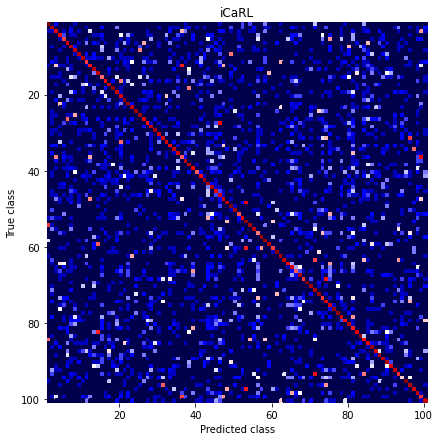

In [7]:
method = mnemonics(randomseed=203)
method.trainer()

In [ ]:
xzz = {0:1, 1:2}